In [1]:
# Imports

import pandas as pd
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

In [2]:
# INPUT PARAMETERS

folder_path = r'E:\SMART GRID FOR EV\SAME_METERS\TESTING_10'   # Specify the folder where your CSV files are located

output_folder = r"E:\SMART GRID FOR EV\RESULTS\NEW_RESULTS"   # Output foler path to save results

split_size = 0.80
EVALUATION_INTERVAL = 200

EPOCHS = 40
time_step =  60
L1 = 15
#L2 = 60
#3 = 60
#L4 = 30

LD1 = 1
Patience = 3

BATCH_SIZE = 256
BUFFER_SIZE = 10000

#scaler = StandardScaler()                                    # Scale of the output and input to match the scale of the layer of LSTM
# Below used Normalize to check!!!
scaler = MinMaxScaler(feature_range = (0,1))                # scale of the output and input inthe range 0-1 to match the scale of the layer of LSTM



In [3]:
# Function to Extract data from csv to Dataframe

def excel_to_df(url):

    match = re.search(r'(\d+)_merged\.csv', url)                    # Extracting meter number from CSV name
    meter_number = match.group(1)
    dataframe = pd.read_csv(url)
    
    df_daily = dataframe.copy()                                                 # Copying main dataframe to create daily consumption data frame
    df_daily['Meter_reading'] =  df_daily.iloc[:, 2:26].sum(axis=1)       # Adding up 24 hours datapoint values
    df_daily = df_daily.drop(df_daily.iloc[:, 1:26],axis=1)                     # Dropping hourly columns after adding

    if (df_daily['Meter_reading'] == 0).any():  # Check if any value in 'Meter_reading' column is zero
        return None, meter_number  # If zero value exists, return None for dataframe

    return df_daily, meter_number



In [4]:
# Normalising and dividing data into Train, Val and test

def data_splitting_shapping(dataset):
    
    if isinstance(dataset, pd.Series):
        target_dataset = dataset #For Transfer learning
    else:
        target_dataset = dataset["Meter_reading"] #For meter prediction

    # Standardize the data before model fitting as it will boost the performance( in neural networks)
    target_dataset = scaler.fit_transform(np.array(target_dataset).reshape(-1,1))       # reshape: convert the univariate 1D array into 2D
    
    train_size = int(len(target_dataset)*split_size)
    test_size = len(target_dataset)- train_size
    val_size = int(train_size*0.20)
    
    train_data = target_dataset[0:train_size-val_size, : ]                # Splitting data into train test Val
    test_data = target_dataset[train_size:len(target_dataset), :1 ]
    val_data = target_dataset[len(target_dataset)-test_size-val_size:len(target_dataset)-test_size, :1 ]

    def create_dataset(dataset, time_step = 1):                 # Function to create X and Y nparray from dataset and timestep for LSTM model
        dataX, dataY = [] , []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step),0]
            dataX.append(a)
            dataY.append(dataset[i + time_step,0])
        return np.array(dataX), np.array(dataY)
    
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    X_val, y_val = create_dataset(val_data, time_step)

    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)         # Reshaping arrays according LSTM model
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

    train_univariate = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_univariate = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
    
    return X_train, X_test, X_val, y_train, y_test, y_val, train_univariate, val_univariate, test_data

In [5]:
# TRANSFER LESRNING LSTM Architecture

def lstm_archi(X_train, y_train, X_val, y_val, train_univariate, val_univariate):
    
    early_stopping = EarlyStopping(monitor = 'loss', patience=3)                 # Define the early stopping callback

    tf.keras.backend.clear_session()
    
    simple_lstm_model = Sequential()
        
    simple_lstm_model.add(LSTM(units=L1, input_shape = (time_step, 1)))      # Model Architecture

    #simple_lstm_model.add(LSTM(units=L2))

    
    #simple_lstm_model.add(LSTM(units=L1, return_sequences= True, input_shape=(time_step, 1)))      # Model Architecture
    #simple_lstm_model.add(Dropout(0.2))

    #simple_lstm_model.add(LSTM(units=L2, return_sequences= True))
    #simple_lstm_model.add(Dropout(0.2))

    #simple_lstm_model.add(LSTM(units=L3, return_sequences= False))
    #simple_lstm_model.add(Dropout(0.2))

    #simple_lstm_model.add(LSTM(units=L4))

    
    simple_lstm_model.add(Dense(units = LD1))

    simple_lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    #history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
    #                               validation_data=val_univariate, validation_steps=50, 
    #                                callbacks=[early_stopping], verbose=0)

    history = simple_lstm_model.fit(X_train, y_train, validation_data = (X_val,y_val), verbose = 0, epochs = EPOCHS ,batch_size = 30)

    return simple_lstm_model, history

In [6]:
# Plotting Model loss

def loss_graph(history):
    plt.figure(figsize=(10, 5))

    # Plot model loss on the left side
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.show()


In [7]:
# Graph plotting function

def plot_graphs(Meter_number, mae_test, mape_test, rmse_test, dataset, test_predictions, actual_test, raw_errors):
    
    # Print the results
    print("=================================")
    print("Results of meter:- ",Meter_number)
    print("MAE:", mae_test)
    print("MAPE:", mape_test)
    print("RMSE:", rmse_test)
    print("=================================")

    # Plot the actual values and test predictions
    indices = range(len(actual_test))                       # Create a range of indices for the data points
    plt.figure(figsize=(12, 6))
    plt.plot(indices, actual_test, label='Actuals', marker='o', linestyle='-')
    plt.plot(indices, test_predictions, label='Test Predictions', marker='x', linestyle='--')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.title('Actuals vs. Test Predictions (Meter: {})'.format(Meter_number))
    plt.legend()
    plt.show()

    #Plot_Energy_Distribution

    #sns.distplot(dataset["Meter_reading"])
    #plt.title('Energy Distribution')


In [8]:
# Model evaluation to find MAE, MAPE, RMSE

def model_eval( simple_lstm_model, scaler, X_test, y_test):

   # Predicting consumption using test data
   
   test_predictions_1 = simple_lstm_model.predict(X_test)

   test_predictions =scaler.inverse_transform(test_predictions_1)

   y_test = y_test.reshape(y_test.shape[0], 1)

   actual_test = scaler.inverse_transform(y_test)

   mean_actual = np.mean(actual_test)  # Calculate the mean of the actual target variable

   # A lower RMSE, MAE, and MAPE for your model compared to the baseline indicate that your model is performing better.
   
   raw_errors = test_predictions - actual_test

   # Calculate MAE (Mean Absolute error)
   mae_test = np.mean(np.abs(test_predictions - actual_test))


   # Calculate MAPE (Mean Absolute Percentage Error)
   #epsilon = 1e-10  # Small constant to avoid division by zero
   denominator = np.where(actual_test != 0, actual_test, 1)
   mape_test = np.mean(np.abs((actual_test - test_predictions) / denominator)) * 100


   # Calculate RMSE (Root Mean Squared Error)
   rmse_test = np.sqrt(np.mean((test_predictions - actual_test) ** 2))

   return mae_test, mape_test, rmse_test, test_predictions, actual_test, mean_actual, raw_errors

In [ ]:
# Results to Excel

def results_OP(Results, output_folder):
    
    # create a DataFrame from the results
    Results_df = pd.DataFrame(Results, columns=['Meter_number', 'MAE', 'MAPE', 'RMSE', 'Time step'])

    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_excel = os.path.join(output_folder, 'Results_L1_{}_timestep_{}_{}.xlsx'.format(L1, time_step, current_time))

    Results_df.to_excel(output_excel, index=False)                  # Save the DataFrame to a CSV file

    if os.path.exists(output_excel):
        print(f"CSV file saved to {output_excel}")
    else:
        print("Error: CSV file not saved.")


In [10]:
# Future value prediction function

def future_predict(test_data, n_steps, days_to_predict, Meter_number, simple_lstm_model):

    #print(len(test_data))          # 366 values
    x_input = test_data[len(test_data)- n_steps:].reshape(1,-1)
    #print(x_input.shape)           # (1, 60)

    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    i = 0
    test = ""

    while(i < days_to_predict):    #prediction for next 30 days
        
        if(len(temp_input)>60):

            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)

            yhat = simple_lstm_model.predict(x_input, verbose=0)
            #print("{} day output {}".format(i,yhat))

            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1

        else:

            x_input = x_input.reshape((1, n_steps,1))

            yhat = simple_lstm_model.predict(x_input, verbose=0)

            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1

    day_new = np.arange(1, len(test_data))
    day_pred = np.arange(len(test_data), len(test_data)+days_to_predict)

    combined_dataplot = np.concatenate((scaler.inverse_transform(test_data[1:]), scaler.inverse_transform(lst_output)))       # Concatenate the actual data and predicted data
    combined_daysplot = np.concatenate((day_new, day_pred))

    plt.figure(figsize=(16, 5))

    plt.plot(combined_daysplot, combined_dataplot, color='blue', label='Actual Data',linewidth=1)  # Actual data in blue, predicted data in red
    plt.plot(day_pred, scaler.inverse_transform(lst_output), color='red', label=f'Predicted Data for next {days_to_predict} days',linewidth=1)      # Highlight the predicted data

    plt.xlabel('Day')
    plt.ylabel('Consumption in KW')
    plt.legend()
    plt.title('Actual and Predicted consumption (Meter: {})'.format(Meter_number))
    plt.grid(True)
    plt.show()

    return lst_output


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15)                1020      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1036 (4.05 KB)
Trainable params: 1036 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


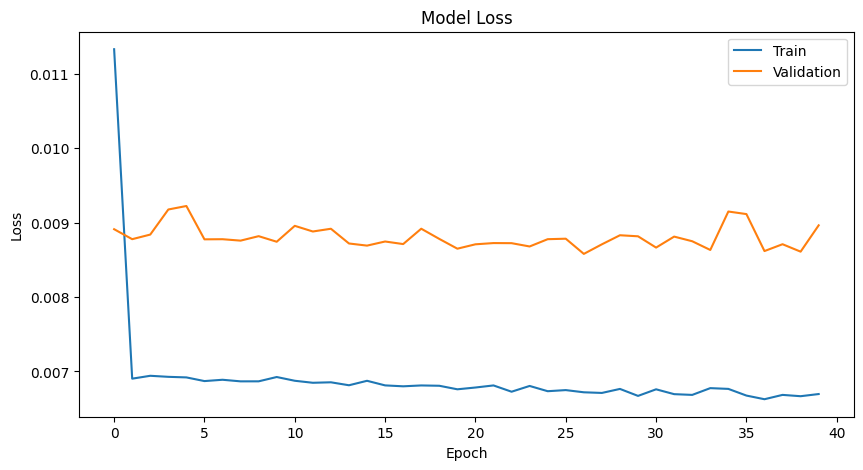

10/10 [==============================] - 0s 5ms/step
Results of meter:-  52529
MAE: 0.4997465173064685
MAPE: 15.933042792809582
RMSE: 0.6742498999516435


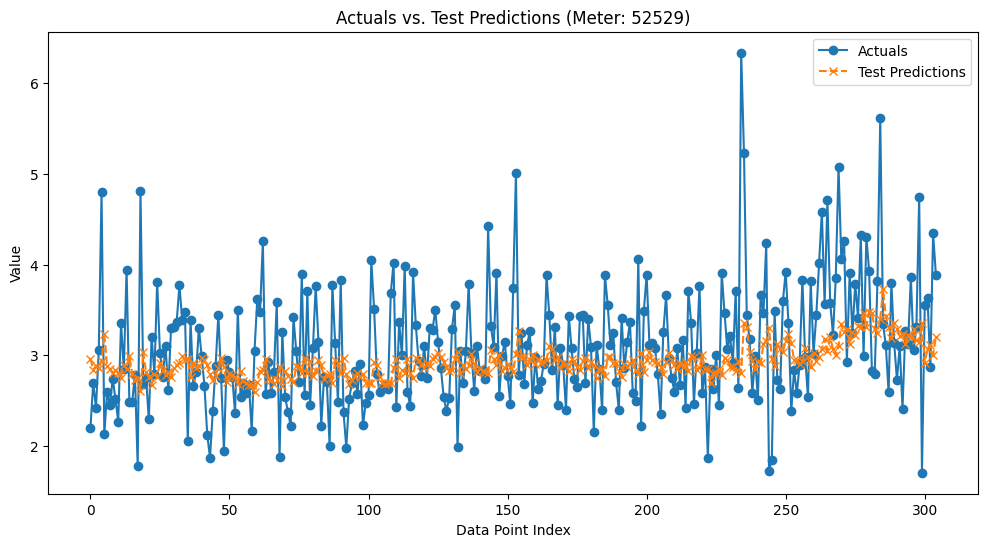

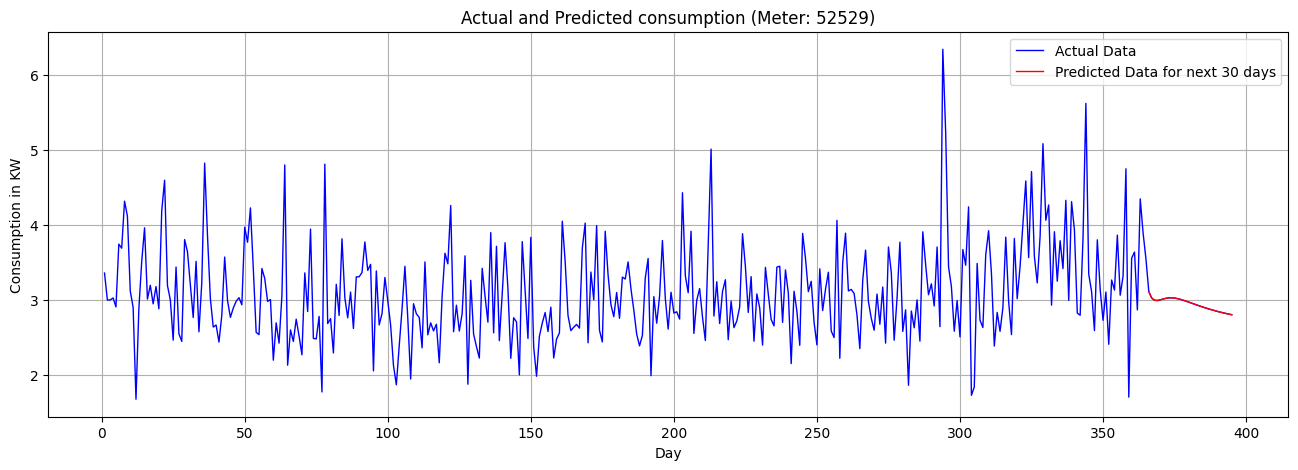

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15)                1020      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1036 (4.05 KB)
Trainable params: 1036 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


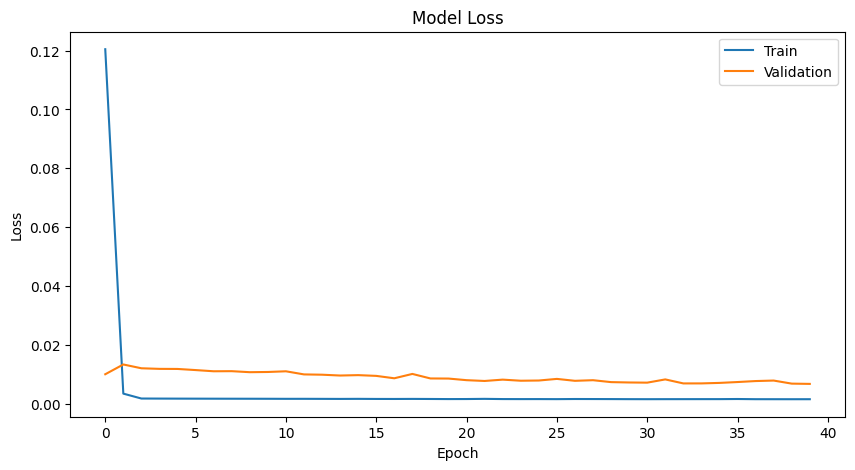

10/10 [==============================] - 0s 5ms/step
Results of meter:-  62697
MAE: 0.055027135655136804
MAPE: 0.6589102011433534
RMSE: 0.0702964814089822


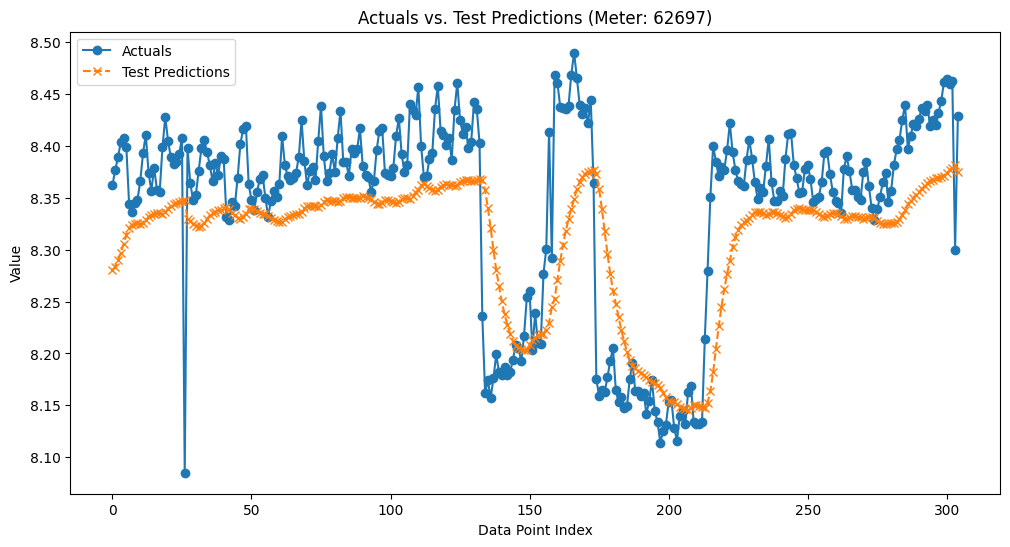

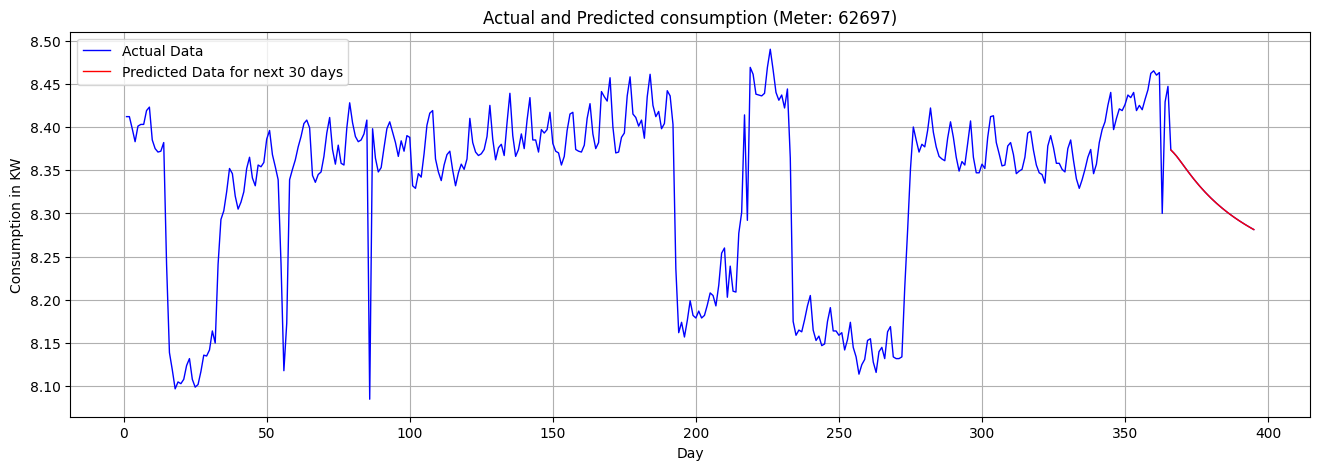

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15)                1020      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1036 (4.05 KB)
Trainable params: 1036 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


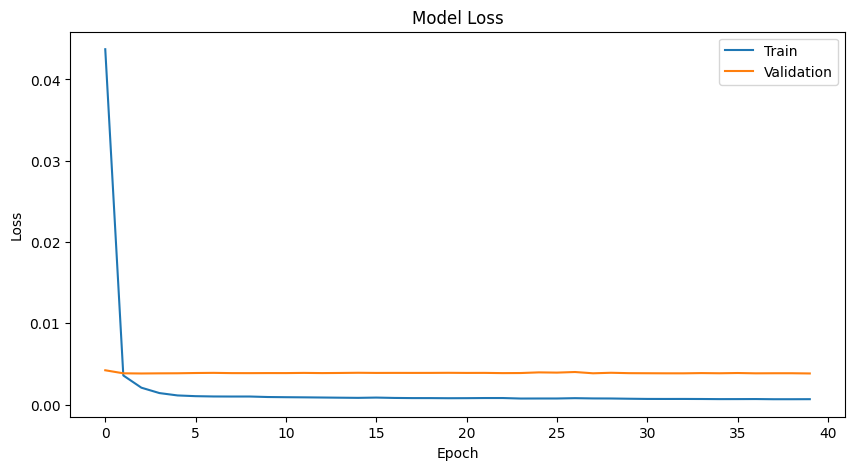

10/10 [==============================] - 0s 5ms/step
Results of meter:-  65481
MAE: 0.09920564712774557
MAPE: 2.0981645202659154
RMSE: 0.19597440782889936


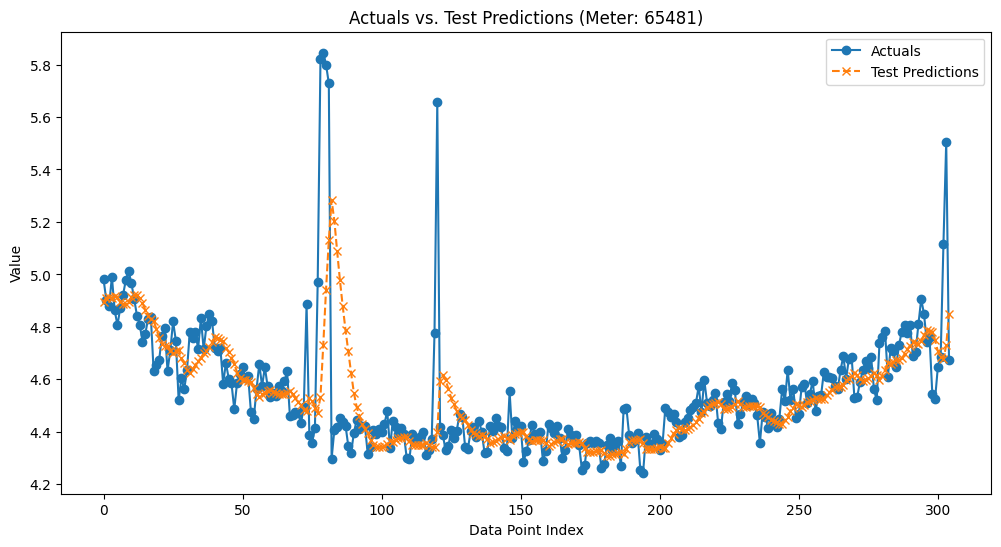

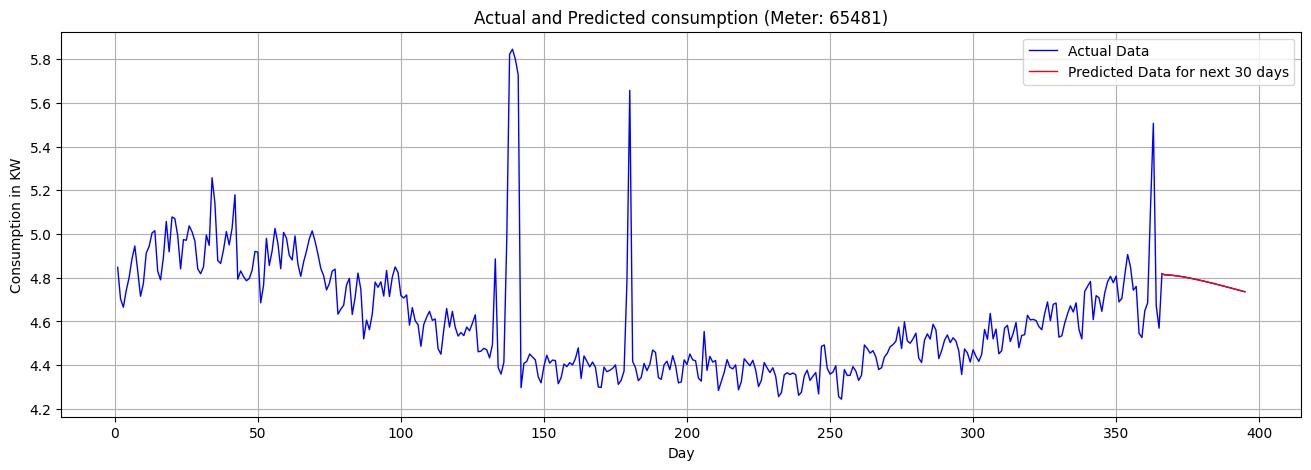

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15)                1020      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1036 (4.05 KB)
Trainable params: 1036 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


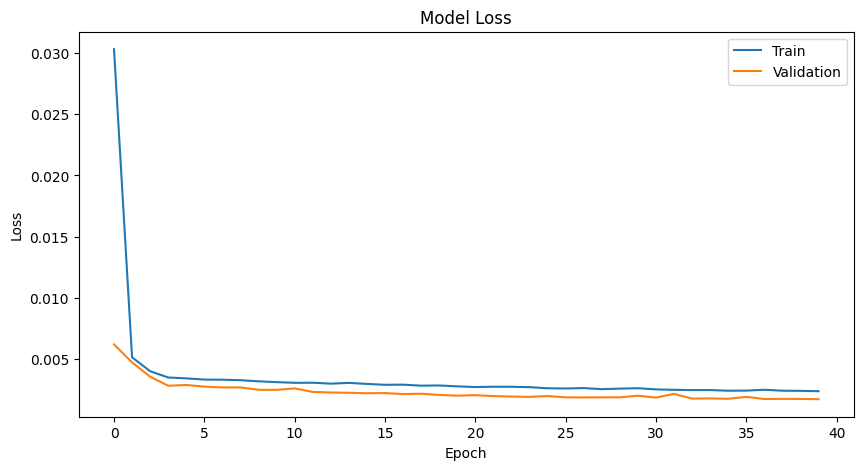

10/10 [==============================] - 0s 5ms/step
Results of meter:-  74265
MAE: 0.39469594026159066
MAPE: 3.1828575437161604
RMSE: 0.5868401127310288


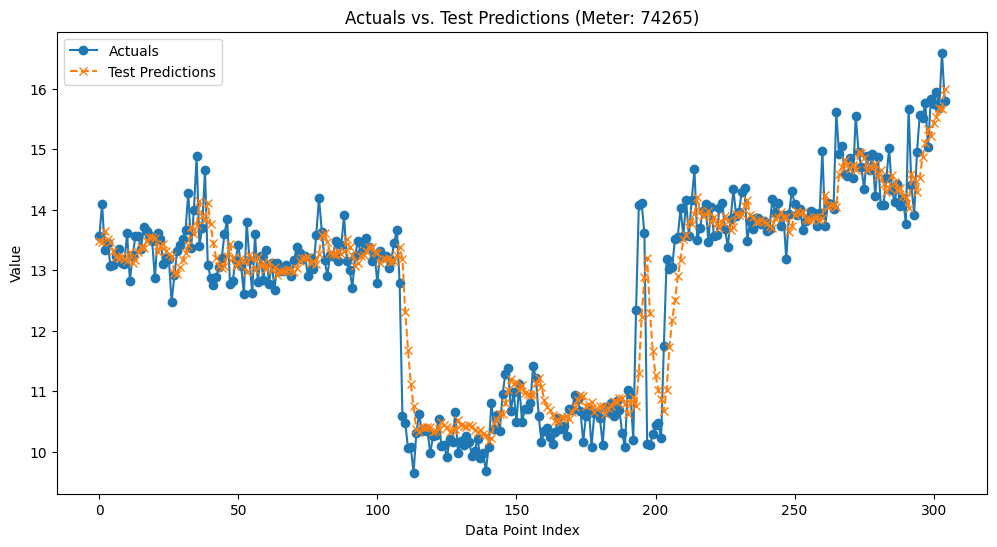

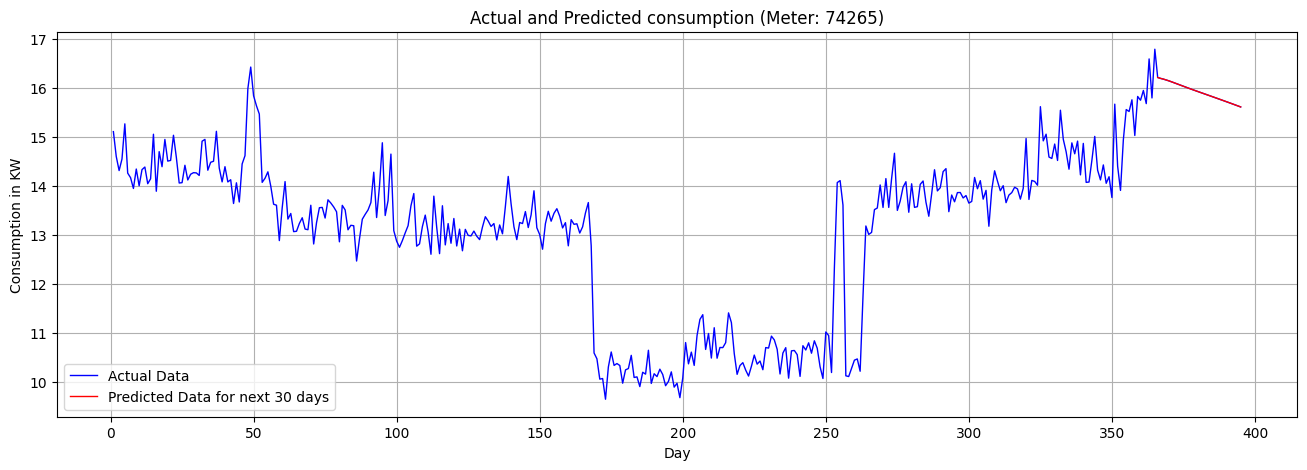

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15)                1020      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1036 (4.05 KB)
Trainable params: 1036 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


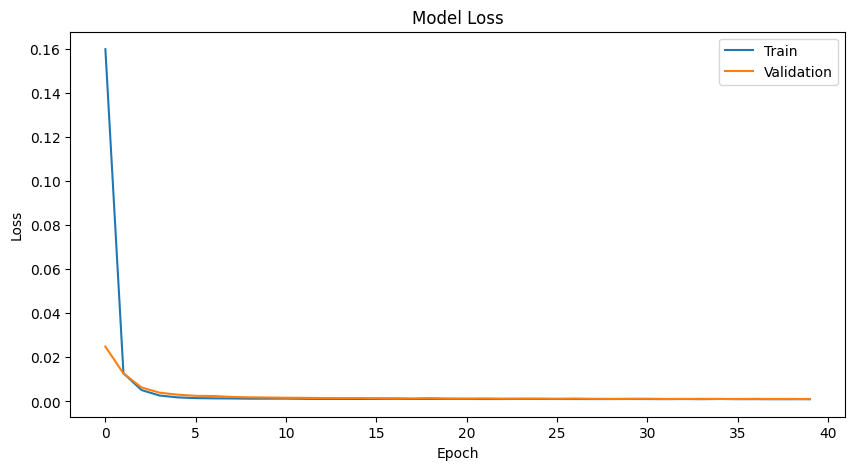

10/10 [==============================] - 0s 6ms/step
Results of meter:-  75761
MAE: 0.3855352603099386
MAPE: 2.107427310036661
RMSE: 0.5055328422200126


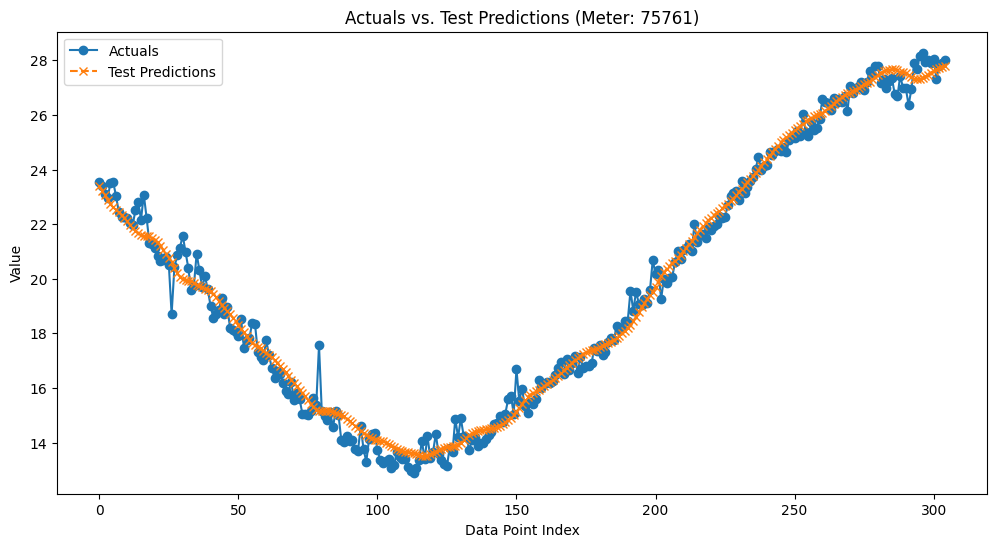

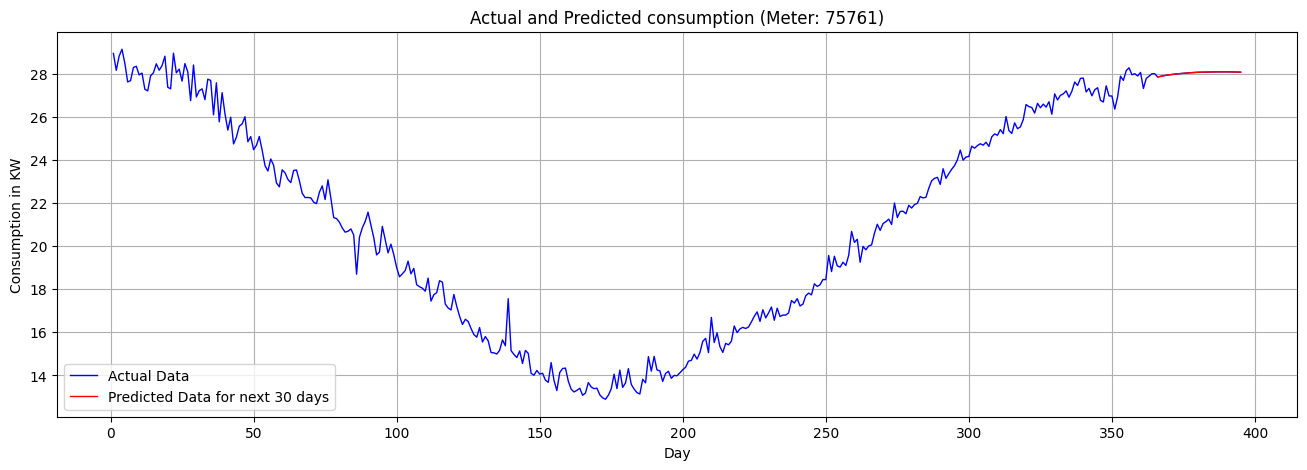

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15)                1020      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1036 (4.05 KB)
Trainable params: 1036 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


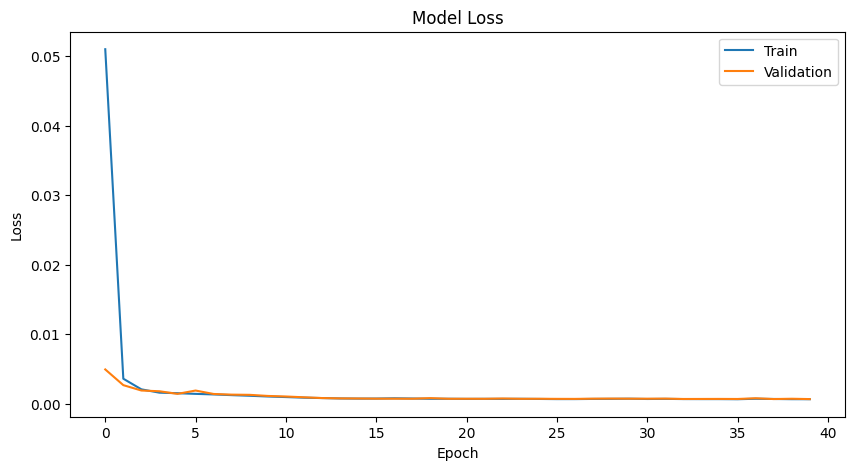

10/10 [==============================] - 0s 6ms/step
Results of meter:-  87177
MAE: 0.3095487632001033
MAPE: 2.7823245213258363
RMSE: 0.43721121937339646


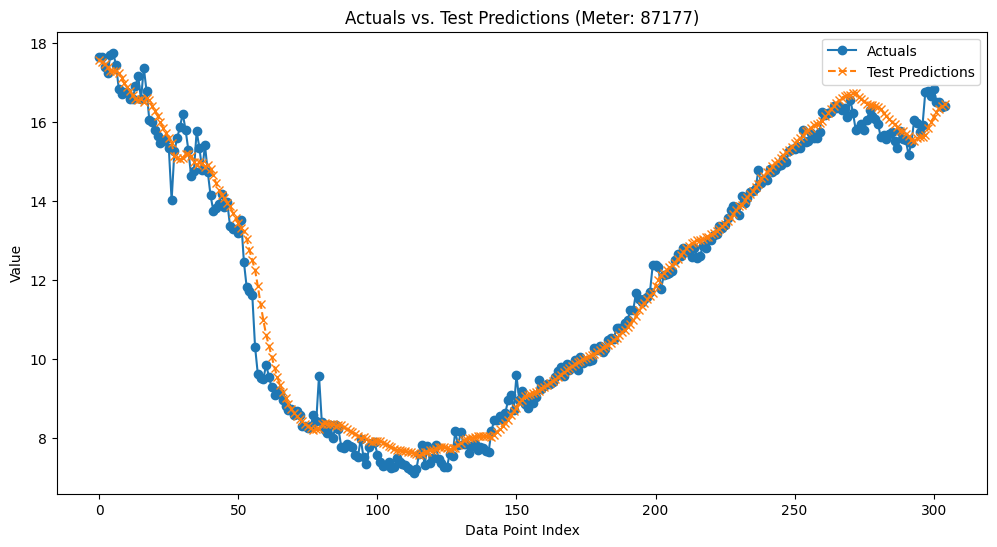

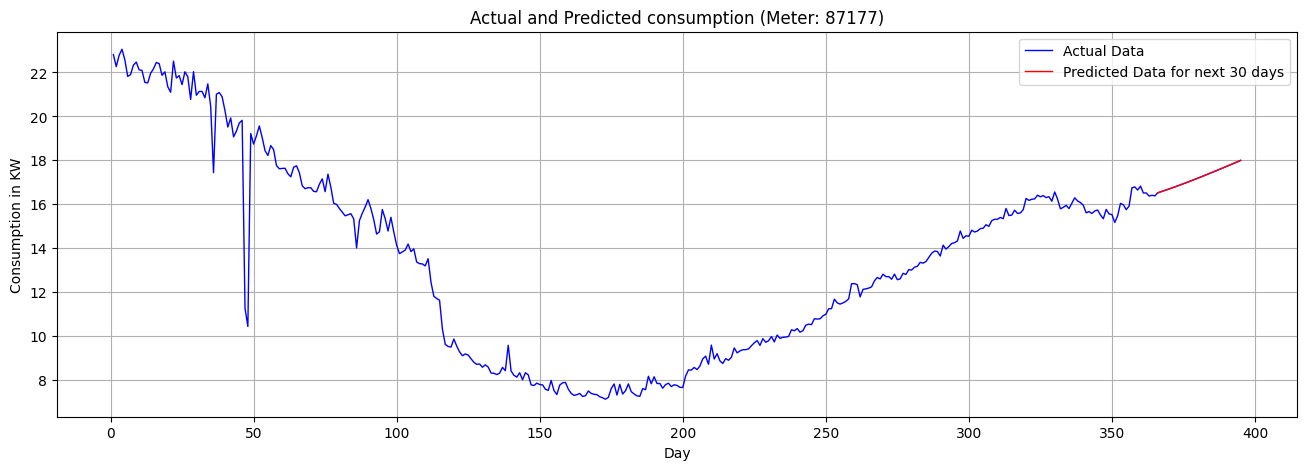

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15)                1020      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1036 (4.05 KB)
Trainable params: 1036 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


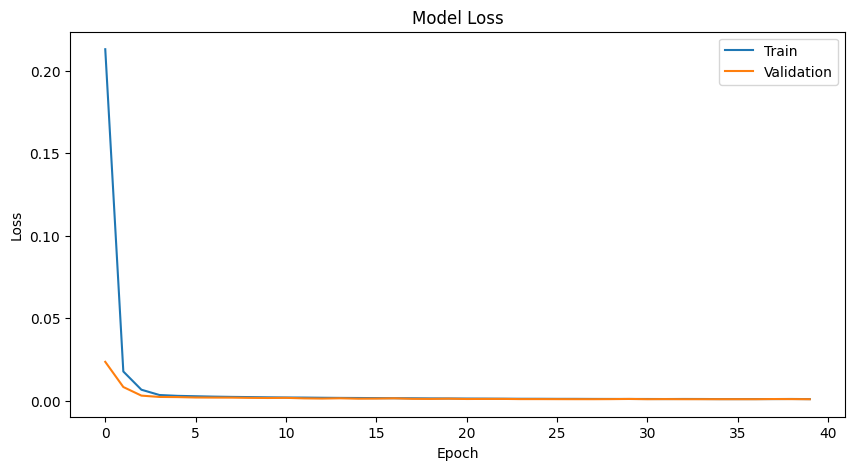

10/10 [==============================] - 1s 4ms/step
Results of meter:-  87801
MAE: 0.4305572170820393
MAPE: 2.688936677373154
RMSE: 0.5760558799411044


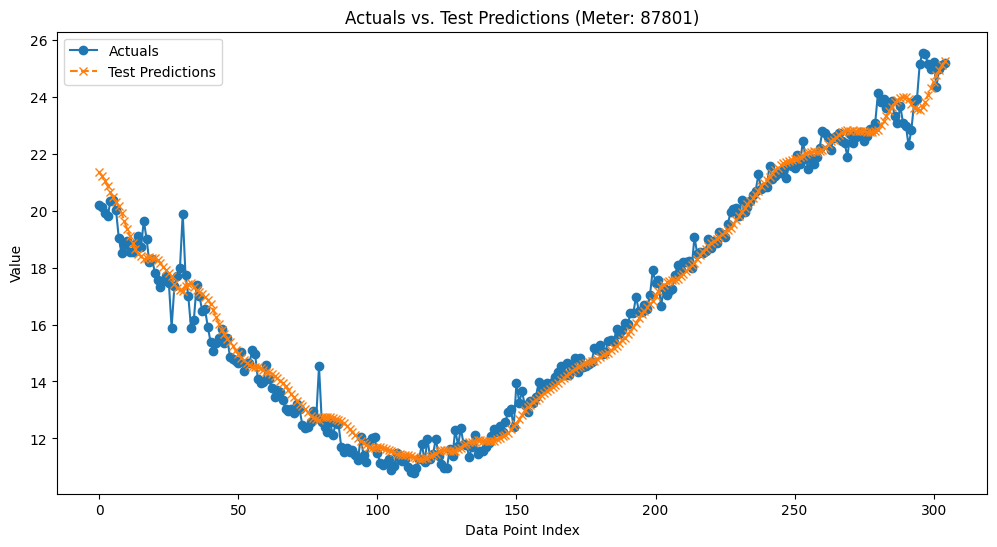

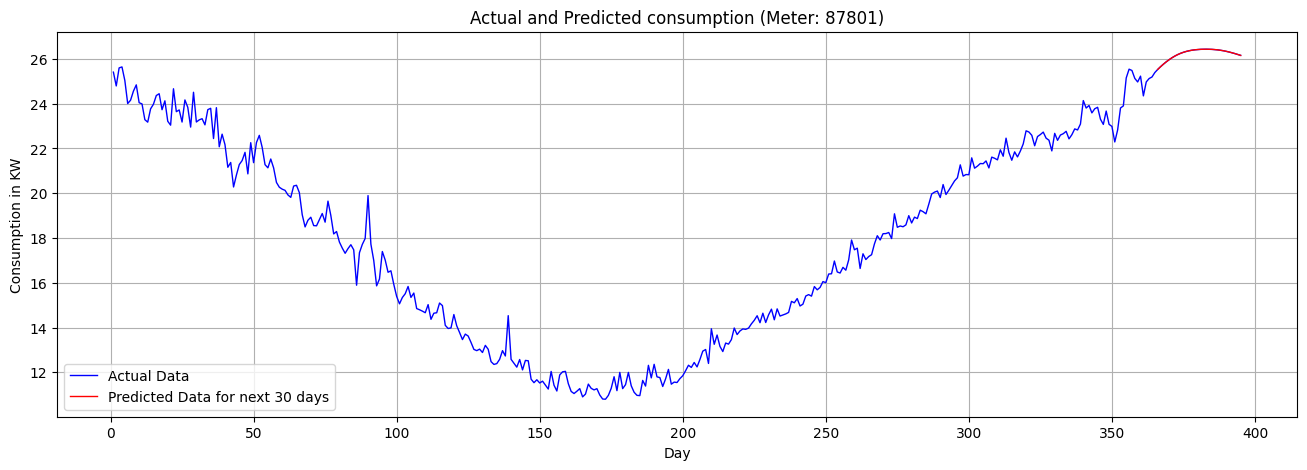

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15)                1020      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1036 (4.05 KB)
Trainable params: 1036 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


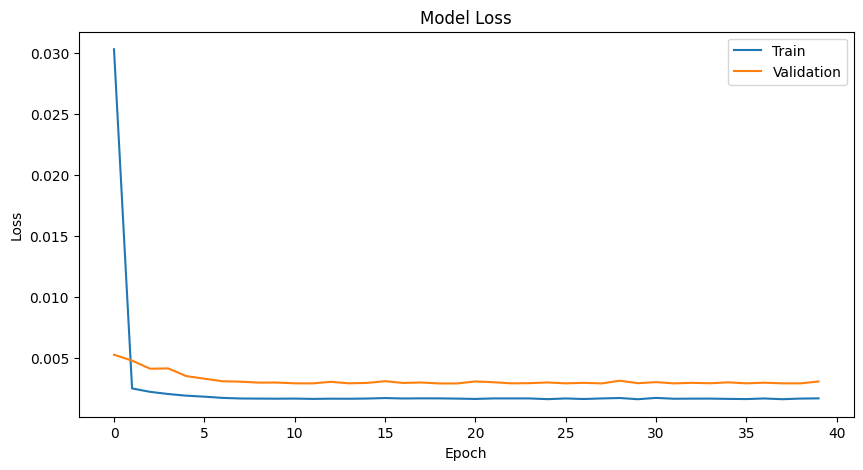

10/10 [==============================] - 0s 5ms/step
Results of meter:-  90153
MAE: 0.0005490492017542712
MAPE: 0.7560283382594242
RMSE: 0.0008171426501165015


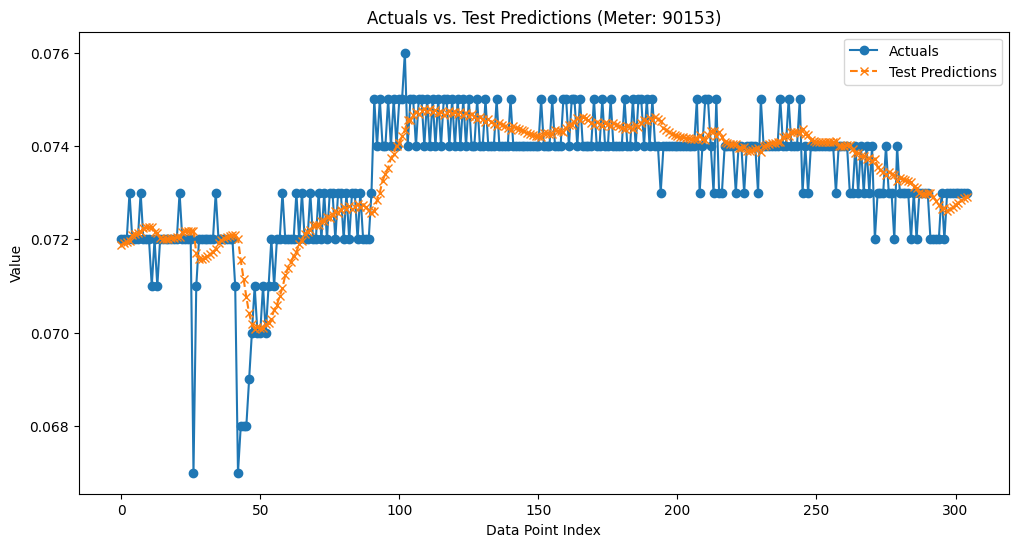

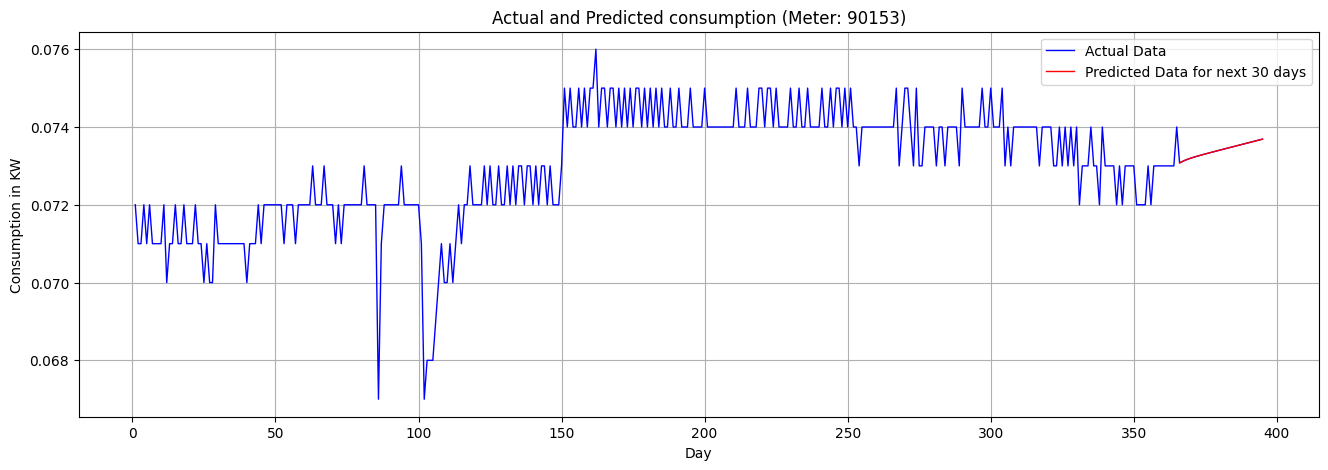

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15)                1020      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1036 (4.05 KB)
Trainable params: 1036 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


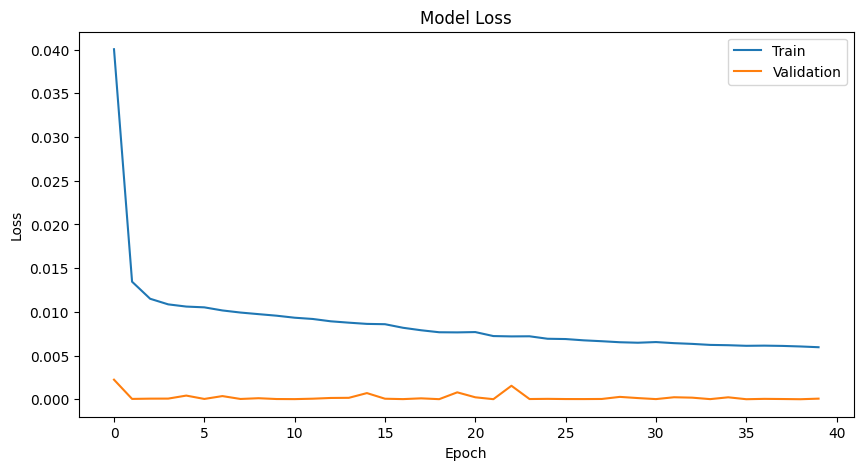

10/10 [==============================] - 0s 5ms/step
Results of meter:-  96049
MAE: 0.0740803265055674
MAPE: 1.1784003800084384
RMSE: 0.08200575768894804


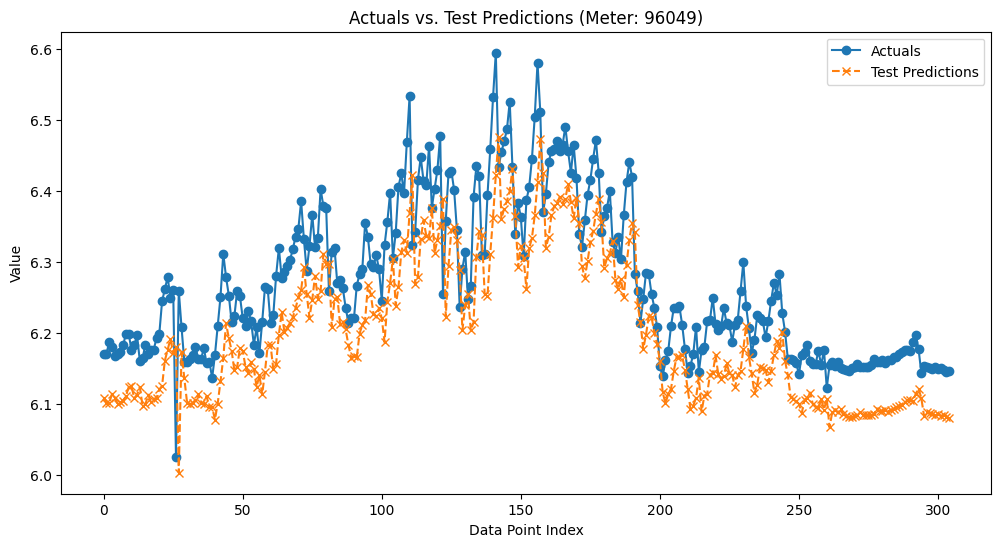

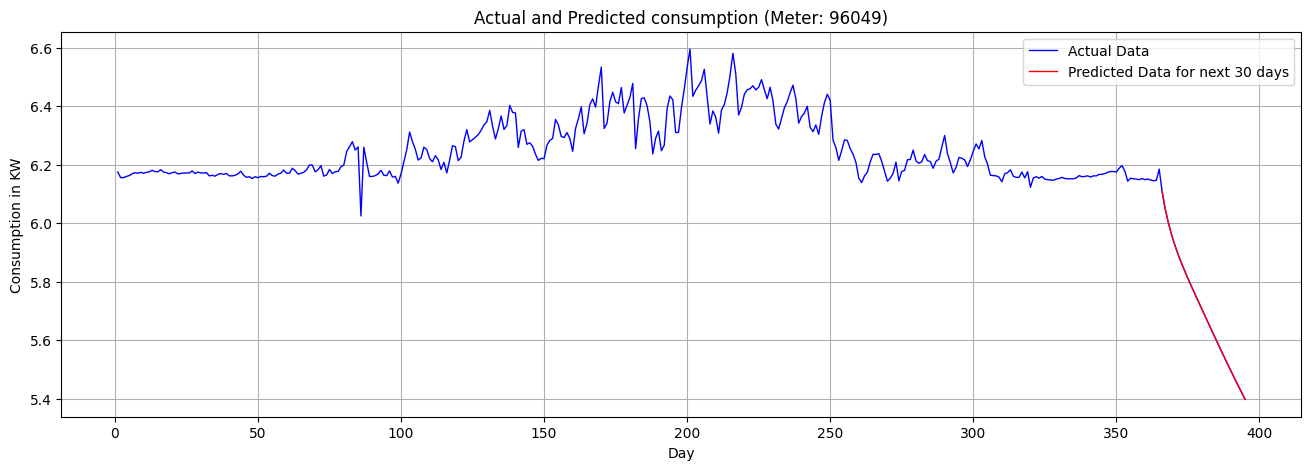

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15)                1020      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1036 (4.05 KB)
Trainable params: 1036 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


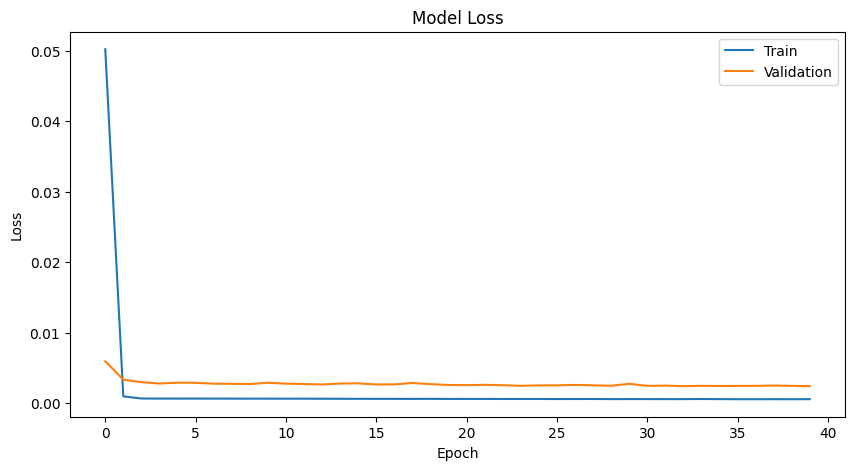

10/10 [==============================] - 0s 5ms/step
Results of meter:-  97497
MAE: 0.13548959702038374
MAPE: 3.0425375796415337
RMSE: 0.22692257810190192


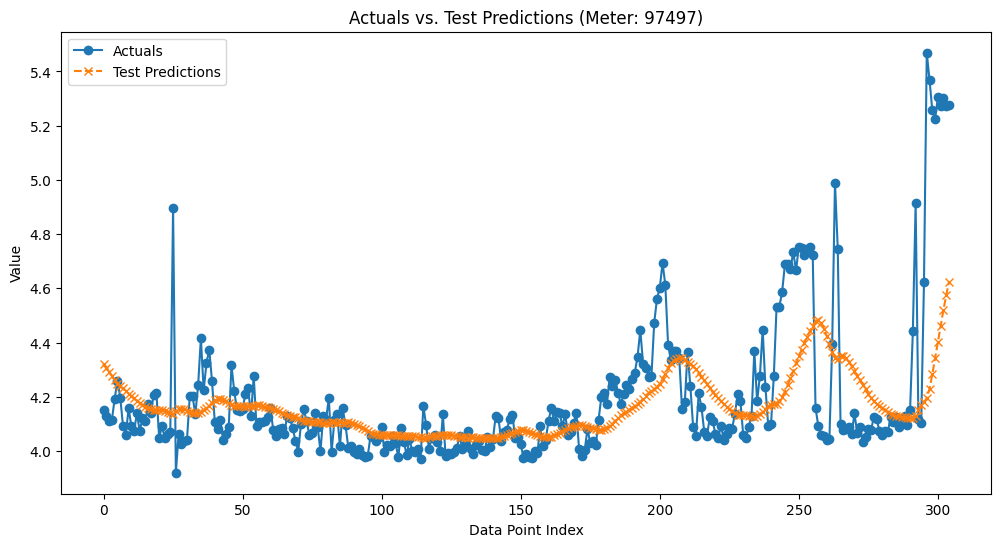

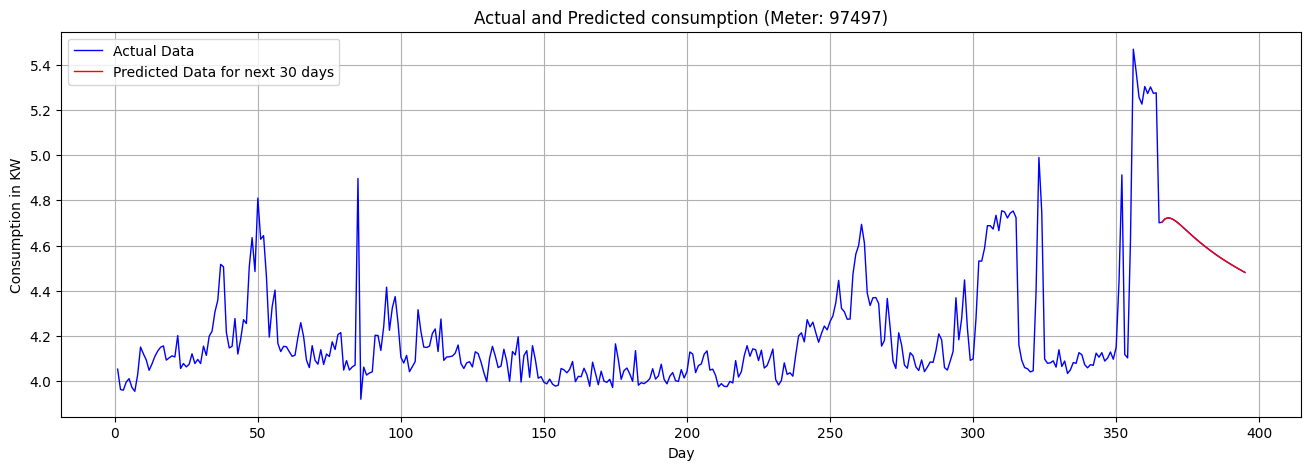

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15)                1020      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1036 (4.05 KB)
Trainable params: 1036 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


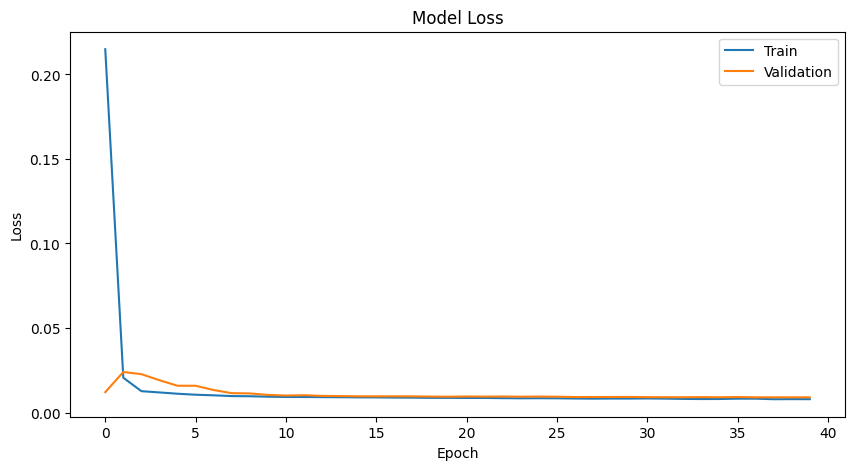

10/10 [==============================] - 0s 5ms/step
Results of meter:-  98633
MAE: 0.0006947110201491687
MAPE: 2.366276402192897
RMSE: 0.0008815842925862546


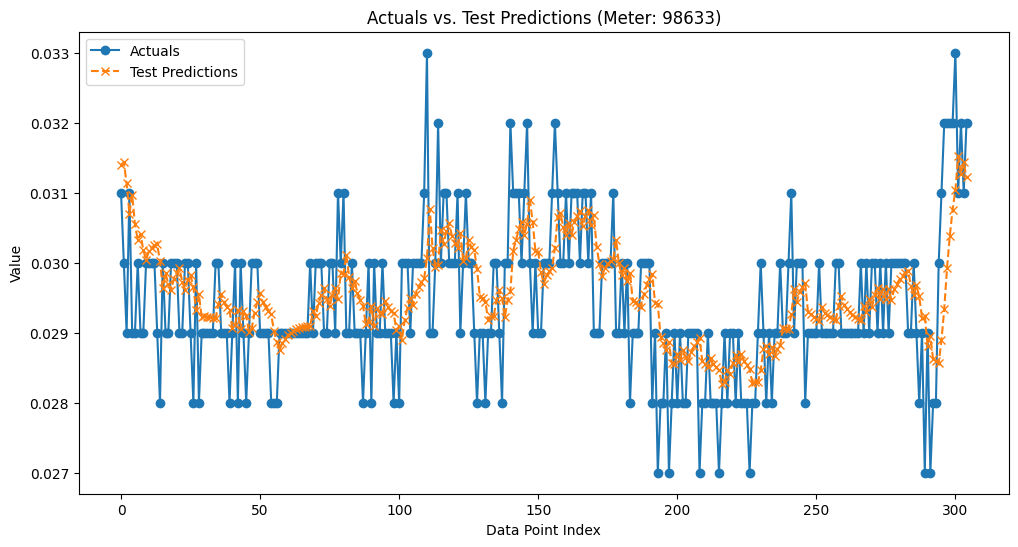

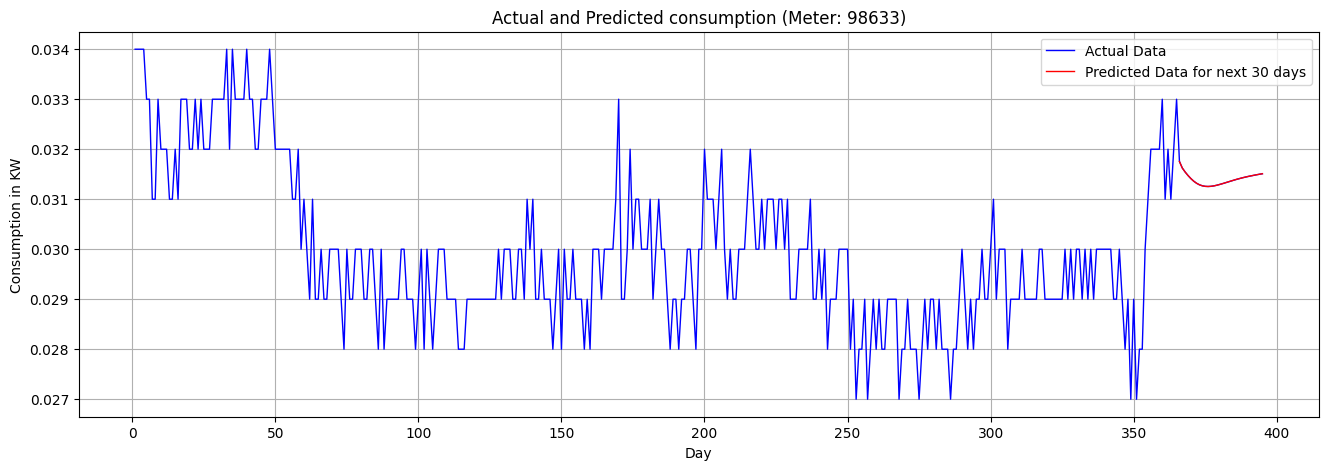

CSV file saved to E:\SMART GRID FOR EV\RESULTS\NEW_RESULTS\Results_L1_15_timestep_60_20240617_114000.xlsx


In [11]:
# meter data reading, predicting and exporting the results

Results = []

for filename in os.listdir(folder_path):                   # Loop through the files in the folder
    if filename.endswith(".csv"):                           
        file_path = os.path.join(folder_path, filename)

        df_daily, Meter_number = excel_to_df(file_path)

        if df_daily is None:  
            continue                                         # Skip to the next CSV file

        dataset = df_daily

        X_train, X_test, X_val, y_train, y_test, y_val, train_univariate, val_univariate, test_data = data_splitting_shapping(dataset)

        simple_lstm_model, history = lstm_archi(X_train, y_train, X_val, y_val, train_univariate, val_univariate)

        simple_lstm_model.summary()

        loss_graph(history)

        mae_test, mape_test, rmse_test, test_predictions, actual_test, mean_actual, raw_errors = model_eval(simple_lstm_model, scaler, X_test, y_test)
    
        plot_graphs(Meter_number,mae_test, mape_test, rmse_test, dataset, test_predictions, actual_test, raw_errors)

        n_steps = 60                                     # Steps to consider to calculate the future          
        days_to_predict = 30                             # demonstrate prediction for next 30 days

        lst_output = future_predict(test_data, n_steps, days_to_predict, Meter_number, simple_lstm_model)

        Results.append([Meter_number, mae_test, mape_test, rmse_test, time_step])

results_OP(Results, output_folder)